##  Semantic Segmentation via Tiramasu with Keras - Final

This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

This code heavily leverages reference examples below:
https://github.com/roebius/deeplearning_keras2/blob/master/nbs2/tiramisu-keras.ipynb
https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb

Reference for discussion on fast.ai forums site.
http://forums.fast.ai/t/lesson-14-wiki/2469

In [1]:
%matplotlib inline
from __future__ import print_function
import importlib
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.internals import find_jar, config_java, java, _java_options
from nltk.tokenize.stanford_segmenter import StanfordSegmenter
from nltk.parse import stanford
import sys
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K, threading, json, re, collections
import tarfile, tensorflow as tf, matplotlib.pyplot as plt, xgboost, operator, random, pickle, glob, os, bcolz
import shutil, sklearn, functools, itertools, scipy
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import matplotlib.patheffects as PathEffects
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, LSHForest
import IPython
from IPython.display import display, Audio
from numpy.random import normal
from gensim.models import word2vec
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import ToktokTokenizer
from functools import reduce
from itertools import chain
from tensorflow.python.framework import ops
#from tensorflow.contrib import rnn, legacy_seq2seq as seq2seq
import keras
from keras_tqdm import TQDMNotebookCallback
from keras.applications.resnet50 import ResNet50, decode_predictions, conv_block, identity_block
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model 
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import constraints 
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.constraints import max_norm
import keras.backend as K
import tempfile  
import logging
from IPython.display import SVG
#import mkl
import matplotlib.pyplot as plt
import h5py
#import graphviz
#import pydotplus
#import pyparsing

np.set_printoptions(threshold=50, edgeitems=20)

def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname): return bcolz.open(fname)[:]


/home/syncweek/anaconda/envs/tf-py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
random.seed(12)
from tensorflow import set_random_seed
set_random_seed(2)

limit_mem()

# Tiramisu / Mobile Apparel Snapshots

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. 
It was designed as a state-of-the-art approach to semantic image segmentation.


## Setup

Modify the following to point to the appropriate paths on your machine

In [5]:
base_dir = os.path.join(os.path.expanduser('~'),'yourfolder')
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
os.chdir(os.path.join(os.path.expanduser('~'),'yourfolder'))
backgroundsegmenter_dir = os.path.join(base_dir, 'backgroundsegmenter', 'res224')
if not os.path.exists(backgroundsegmenter_dir):
    os.makedirs(backgroundsegmenter_dir)
Test_Img_dir = os.path.join(backgroundsegmenter_dir, 'Test_Img')
Test_Mask_dir = os.path.join(backgroundsegmenter_dir, 'Test_Mask_Img')
Train_Img_dir = os.path.join(backgroundsegmenter_dir, 'Train_Img')
Train_Mask_dir = os.path.join(backgroundsegmenter_dir, 'Train_Mask_Img')
PATH = '/yourfolder/backgroundsegmenter/'
###############################################################################################
# Attach blob storage account and read sample files names into lists for training and test
###############################################################################################
# identify the storage account
from azure.storage.blob import BlockBlobService
block_blob_service = BlockBlobService(account_name='yourstgacctname', account_key='yourstorageaccountkey==')
print('block_blob_service yourstorageaccountname storage attached')

# Create  filters
inputlist=[]
justmobileimage = 'quick.jpg'
justcatalogueimage = '_14_f.jpg'
maskgif = 'mask.gif'
mask3dnpy = 'dmask.npy'

block_blob_service storage yourstorageaccountname attached


In [6]:
print(block_blob_service.list_blobs('data', prefix='catalogue-image-retrieval-249-516x516/foreground_segmented_improved/'))

In [7]:
inputlist = []
listgenerator = block_blob_service.list_blobs('data', prefix='catalogue-image-retrieval-249-516x516/')
for blob in listgenerator:
    inputlist.append(blob.name) 
print(len(inputlist))

#filter mobile image list
mobileimagelist=[]
for text in inputlist:
    if 'mobile' in text:
            if justmobileimage in text:
                mobileimagelist.append(text)
print('number of mobile images',len(mobileimagelist))
mobileimagelist = sorted(mobileimagelist)

#filter mobile image list
mobilemasknpy_list=[]
for text in inputlist:
    if 'foreground_segmented_improved/' in text:
            if mask3dnpy in text:
                mobilemasknpy_list.append(text)
print('number of mobile mask numpy arrays',len(mobilemasknpy_list))
mobilemasknpy_list = sorted(mobilemasknpy_list)

20672
number of mobile images 249
number of mobile mask numpy arrays 249


In [8]:
#########################################
#Seperate Train and Test per CY's script
#########################################

Mobile_img_list = sorted(mobileimagelist)
mobilemasknpy_list = sorted(mobilemasknpy_list)

# generate 25 random number from 249, to be used as indexes
test_index = random.sample(range(len(Mobile_img_list)), round(len(Mobile_img_list)*.2)); #test_index

Mobile_Img_test_list = [Mobile_img_list[i] for i in test_index]; #test_list
Mobile_Img_test_list = sorted(Mobile_Img_test_list)
print('length of Mobile_Img_test_list',len(Mobile_Img_test_list))

Mobilemasknpy_test_list = [mobilemasknpy_list[i] for i in test_index]; #test_list
Mobilemasknpy_test_list = sorted(Mobilemasknpy_test_list)
print('length of Mobilemasknpy_test_list',len(Mobilemasknpy_test_list))

#filter test out of mobile image list to yeild train list
Mobile_Img_train_list = []
for text in Mobile_img_list:
    if text not in Mobile_Img_test_list:
        Mobile_Img_train_list.append(text)
print('length of Mobile_Img_train_list',len(Mobile_Img_train_list))

#filter test out of catalogue image list to yeild train list
Mobilemasknpy_train_list = []
for text in mobilemasknpy_list:
    if text not in Mobilemasknpy_test_list:
            Mobilemasknpy_train_list.append(text)
print('length of Mobilemasknpy_train_list',len(Mobilemasknpy_train_list))

print(Mobile_Img_train_list[0:1])
print(Mobilemasknpy_train_list[0:1])
print(Mobile_Img_test_list[0:1])
print(Mobilemasknpy_test_list[0:1])

length of Mobile_Img_test_list 50
length of Mobilemasknpy_test_list 50
length of Mobile_Img_train_list 199
length of Mobilemasknpy_train_list 199
['catalogue-image-retrieval-249-516x516/mobile/12031854sd.quick.jpg']
['catalogue-image-retrieval-249-516x516/foreground_segmented_improved/12031854sd.quick.3dmask.npy']
['catalogue-image-retrieval-249-516x516/mobile/12027731pn.quick.jpg']
['catalogue-image-retrieval-249-516x516/foreground_segmented_improved/12027731pn.quick.3dmask.npy']


In [9]:
############################################
#Read files from blob and write them locally
############################################
sample = { }
currentsample1 = []
currentsample = []
count= 0
TRAIN_SAMPLE_SIZE = len(Mobile_Img_train_list)
TEST_SAMPLE_SIZE = len(Mobile_Img_test_list)
Mobile_Img_train_list1=[]
Mobile_Img_test_list1=[]
Mobilemasknpy_train_list1=[]
Mobilemasknpy_test_list1=[]

Test_Img_dir = os.path.join(backgroundsegmenter_dir, 'Test_Img')
Test_NpyMask_dir = os.path.join(backgroundsegmenter_dir, 'Test_Npy')
Train_Img_dir = os.path.join(backgroundsegmenter_dir, 'Train_Img')
Train_NpyMask_dir = os.path.join(backgroundsegmenter_dir, 'Train_Npy')

print(Test_Img_dir )
print(Test_NpyMask_dir )
print( Train_Img_dir)
print(Train_NpyMask_dir )

while (count < TRAIN_SAMPLE_SIZE):
    currentsample1 = Mobile_Img_train_list[count].replace('catalogue-image-retrieval-249-516x516/mobile/','')
    full_path_to_file2 = os.path.join(Train_Img_dir, currentsample1)                          
#    block_blob_service.get_blob_to_path('tiramisumodeldata', currentsample1,full_path_to_file2)
    Mobile_Img_train_list1.append(currentsample1)
    count=count+1

sample = { }
count= 0
while (count < TRAIN_SAMPLE_SIZE):
    currentsample1 = Mobilemasknpy_train_list[count].replace('catalogue-image-retrieval-249-516x516/foreground_segmented_improved/','')
    full_path_to_file2 = os.path.join(Train_NpyMask_dir, currentsample1)
#    block_blob_service.get_blob_to_path('tiramisumodeldata', currentsample1,full_path_to_file2)
    Mobilemasknpy_train_list1.append(currentsample1)
    count=count+1
    
sample = { }
count= 0
while (count < TEST_SAMPLE_SIZE):
    currentsample1 = Mobile_Img_test_list[count].replace('catalogue-image-retrieval-249-516x516/mobile/','')
    full_path_to_file2 = os.path.join(Test_Img_dir, currentsample1)
#    block_blob_service.get_blob_to_path('tiramisumodeldata', currentsample1,full_path_to_file2)
    Mobile_Img_test_list1.append(currentsample1)
    count=count+1
    
sample = { }
count= 0
while (count < TEST_SAMPLE_SIZE):
    currentsample1 = Mobilemasknpy_test_list[count].replace('catalogue-image-retrieval-249-516x516/foreground_segmented_improved/','')
    full_path_to_file2 = os.path.join(Test_NpyMask_dir, currentsample1)
#    block_blob_service.get_blob_to_path('tiramisumodeldata', currentsample1,full_path_to_file2)
    Mobilemasknpy_test_list1.append(currentsample1)
    count=count+1

Mobile_Img_train_list1=sorted(Mobile_Img_train_list1)
Mobile_Img_test_list1=sorted(Mobile_Img_test_list1)
Mobilemasknpy_train_list1=sorted(Mobilemasknpy_train_list1)
Mobilemasknpy_test_list1=sorted(Mobilemasknpy_test_list1)

print(Mobile_Img_train_list1[0:1])
print(Mobilemasknpy_train_list1[0:1])
print(Mobile_Img_test_list1[0:1])
print(Mobilemasknpy_test_list1[0:1])

/home/syncweek/yourfolder/backgroundsegmenter/res224/Test_Img
/home/syncweek/yourfolder/backgroundsegmenter/res224/Test_Npy
/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Img
/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Npy
['12031854sd.quick.jpg']
['12031854sd.quick.3dmask.npy']
['12027731pn.quick.jpg']
['12027731pn.quick.3dmask.npy']


In [10]:
frames_path = Train_Img_dir
labels_path = Train_Mask_dir
PATH = backgroundsegmenter_dir

### Loading labels
Our images also have labels defining the segments of the input image. 
We're going to load both the images and the labels.

We have the numpy array representation of the mask of apparel vs. background.
Here we leveraged the hand-labeled sample of 249 mobile snapshots

In [11]:
frames_path = Train_Img_dir 
print(frames_path)
npylabels_path = Train_NpyMask_dir
print(npylabels_path)

/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Img
/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Npy


In [12]:
fnameslist = pd.DataFrame(Mobile_Img_train_list1)
len(fnameslist)
npy_fnameslist = pd.DataFrame(Mobilemasknpy_train_list1)
len(npy_fnameslist)

199

199

In [13]:
lnames = sorted(glob.glob(os.path.join(npylabels_path,'*.npy'))) 
len(lnames)
#compare to ensure we've got the right order
print(lnames[0:2])

fnames = sorted(glob.glob(os.path.join(frames_path,'*.jpg'))) # +'*.jpg'
len(fnames)
print(fnames[0:2])

199

['/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Npy/12031854sd.quick.3dmask.npy', '/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Npy/12039979ac.quick.3dmask.npy']


199

['/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Img/12031854sd.quick.jpg', '/home/syncweek/yourfolder/backgroundsegmenter/res224/Train_Img/12039979ac.quick.jpg']


## Load Test Data

In [14]:
#Get folder path  for source images and labels
Test_Img_dir = os.path.join(backgroundsegmenter_dir, 'Test_Img')
Test_Npy_dir = os.path.join(backgroundsegmenter_dir, 'Test_Npy')

frames_path_test = Test_Img_dir 
npylabels_path_test = Test_Npy_dir

#Get file list of source images and labels, no path
fnameslist_test = pd.DataFrame(Mobile_Img_test_list1)
labelslist_test = pd.DataFrame(Mobilemasknpy_test_list1)

#Get full path and file list of source images and labels
fnames_test = sorted(glob.glob(os.path.join(frames_path_test,'*.jpg') ))
lnames_test = sorted(glob.glob(os.path.join(npylabels_path_test,'*.npy')))

#compare to ensure we've got the right order
#print(lnames_test[0:2])
#print(fnames_test[0:2])

## Data Transformation

In [15]:
#I modified the images to 512x512, but likely should have just kept to 516x516
img_sz = (224,224)
#img_sz = (516,516)

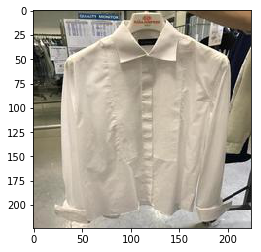

In [16]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))
def open_array(fn): return np.array(lnames)
plt.imshow(img)

In [17]:
#Load Training Arrays
imgs = np.stack([open_image(fn) for fn in fnames]).astype(np.float32)
print('imgs.shape',imgs.shape)

#labels=np.zeros((75,512,512,3))
labels=np.stack([np.load(f) for f in lnames]).astype(np.float32)
labels=labels[:,:,:,0] 
labels=labels[:,:,:,None]* np.ones(1, dtype=int)[None, None,None, :]
print('labels.shape',labels.shape)


imgs.shape (199, 224, 224, 3)
labels.shape (199, 224, 224, 1)


In [18]:
#Load Testing Arrays
imgs_test = np.stack([open_image(fn) for fn in fnames_test]).astype(np.float32)
print('imgs_test.shape',imgs_test.shape)

#labels_test=np.zeros((25,512,512,3))
labels_test=np.stack([np.load(f) for f in lnames_test]).astype(np.float32)
labels_test=labels_test[:,:,:,0] 
labels_test=labels_test[:,:,:,None]* np.ones(1, dtype=int)[None, None,None, :]

print('labels_test.shape',labels_test.shape)

imgs_test.shape (50, 224, 224, 3)
labels_test.shape (50, 224, 224, 1)


In [19]:
img_sz + (1,)

(224, 224, 1)

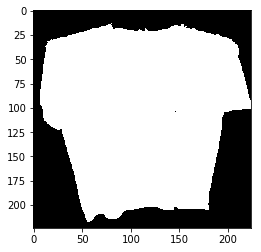

In [20]:
#Check training labels
plt.imshow(labels[2].reshape(img_sz ), cmap="binary");
#labels[1]

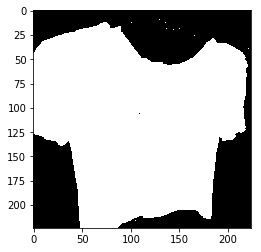

In [21]:
#Check test labels
plt.imshow(labels_test[5].reshape(img_sz), cmap='binary');
#labels[1]

Normalize pixel values.

Save array for easier use.

In [22]:
print(PATH)

/home/syncweek/yourfolder/backgroundsegmenter/res224


In [23]:
save_array(os.path.join(PATH,'results/imgs.bc'), imgs)
save_array(os.path.join(PATH,'results/labels.bc'), labels)
save_array(os.path.join(PATH,'results/imgs_test.bc'), imgs_test)
save_array(os.path.join(PATH,'results/labels_test.bc'), labels_test)



## Training and Test Arrays Saved and Reloaded

In [24]:
#PATH = '/yourfolder/TiramisuData/'
#backgroundsegmenter_dir = os.path.join(base_dir, 'backgroundsegmenter')

PATH=backgroundsegmenter_dir
imgs = load_array(os.path.join(PATH,'results/imgs.bc'))
imgs = imgs.astype(np.float)
labels = load_array(os.path.join(PATH,'results/labels.bc'))
labels = labels.astype(np.float)
imgs_test = load_array(os.path.join(PATH,'results/imgs_test.bc'))
imgs_test = imgs_test.astype(np.float)
labels_test = load_array(os.path.join(PATH,'results/labels_test.bc'))
labels_test = labels_test.astype(np.float)
#check shape
imgs.shape
labels.shape
imgs_test.shape
labels_test.shape


(199, 224, 224, 3)

(199, 224, 224, 1)

(50, 224, 224, 3)

(50, 224, 224, 1)

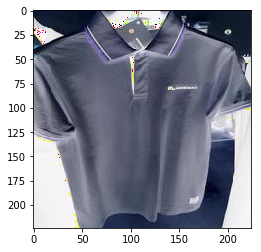

In [25]:
plt.imshow(imgs_test[3])#*0.3+0.4)

### Standardize

In [26]:
#subtract mean, divide by standard deviation
imgs-=0.4
imgs/=0.3

imgs_test-=0.4
imgs_test/=0.3
#imgs_min  =imgs[3].astype(np.float64).min()

print('imgs shape',imgs.shape)
print('imgs_test shape',imgs_test.shape)

imgs shape (199, 224, 224, 3)
imgs_test shape (50, 224, 224, 3)


In [27]:
n,r,c,ch = imgs.shape

## Preprocessing

### Generator

This implementation employs data augmentation on our source data. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [28]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [29]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [30]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([7, 9, 0]),
 array([6, 8, 2]),
 array([1, 3, 5]),
 array([4]),
 array([8, 2, 5])]

In [31]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True): 
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o): 
        #modified to avoid cropping in the middle of the image which would result in a completely black label
        start = random.randint(0, i-o) if self.train else (i-o)
        #start = random.randint(0, int(i/o)-1)*int(i/int(i/o)) if self.train else int(i/int(i/o))
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the first image.

In [32]:
segm_sz = img_sz #(256,256)
sg = segm_generator(imgs, labels, 1,  train=False)
b_img, b_label = next(sg)
print(b_img.shape)
plt.imshow(b_img[0]*0.3+0.4);

(1, 224, 224, 3)


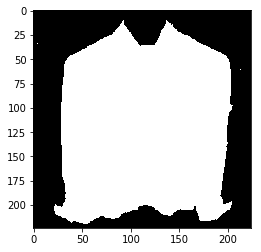

In [33]:
plt.imshow(b_label[0].reshape(segm_sz), cmap='binary');

In [34]:
plt.imshow(imgs[0]*0.3+0.4);

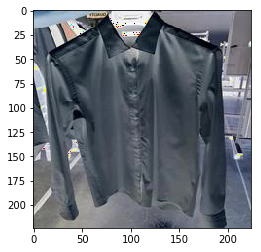

In [35]:
sg = segm_generator(imgs, labels, 2,out_sz=segm_sz, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

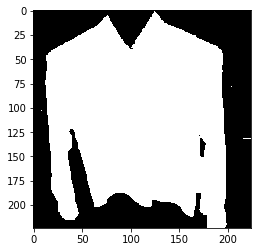

In [36]:
plt.imshow(b_label[0].reshape(segm_sz), cmap='binary');

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

In [37]:
def parse_code(l):
    a,b = l.strip().split("\t")
    return tuple(int(o) for o in a.split(' ')), b

In [38]:
label_codes,label_names = zip(*[
    parse_code(l) for l in open(os.path.join(PATH,"label_colors_01.txt"))])

In [39]:
label_codes,label_names = list(label_codes),list(label_names)
print('label codes',label_codes)
print('label names',label_names)

label codes [(0, 0, 0), (1, 1, 1)]
label names ['Foreground', 'Background']


Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [40]:
list(zip(label_codes,label_names))[:3]

[((0, 0, 0), 'Foreground'), ((1, 1, 1), 'Background')]

In [41]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}
print(code2id)
print(id2code)

{(0, 0, 0): 0, (1, 1, 1): 1}
{0: (0, 0, 0), 1: (1, 1, 1)}


We're going to map each unique pixel color to an integer so we can classify w/ our NN. (Think how a fill-in-the color image looks)

We'll include an integer for erroneous pixel values.

In [42]:
failed_code = len(label_codes)+1
print(failed_code)

3


In [43]:
label_codes.append((0, 0, 0))
label_names.append('unk')

Create labeled source mobile mages

In [44]:
print(labels.dtype)
print(type(labels))


float64
<class 'numpy.ndarray'>


Now we'll create integer-mapped labels for all our colored images.

In [45]:

labels_int =labels
save_labels_int = labels_int
np.count_nonzero(labels_int==failed_code)

0

Set erroneous pixels to zero.

In [46]:
labels_int[labels_int==failed_code]=0
np.unique(labels_int)

array([0., 1.])

In [47]:
save_array(os.path.join(PATH,'results/labels_int.bc'), labels_int)

In [48]:
labels_int = load_array(os.path.join(PATH,'results/labels_int.bc'))

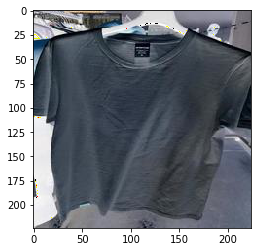

In [49]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

Here is an example of how the segmented image looks.

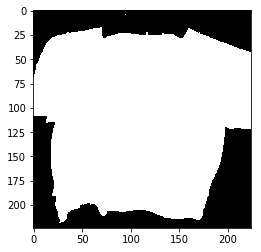

In [50]:
plt.imshow(b_label[0].reshape(224,224), cmap='binary');

### Test set

Convert test set names to expected values, set training/test images and labels.

In [51]:
trn = imgs
trn_labels = labels
test = imgs_test
test_labels = labels_test
trn.shape
trn_labels.shape
test.shape
test_labels.shape

(199, 224, 224, 3)

(199, 224, 224, 1)

(50, 224, 224, 3)

(50, 224, 224, 1)

In [52]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [53]:
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import History


In [54]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)  # Keras 2
def relu_bn(x): return relu(bn(x))
def concat(xs): return concatenate(xs)  # Keras 2

In [55]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, (sz, sz), padding='same', strides=(stride,stride), kernel_regularizer=l2(wd), kernel_initializer='lecun_uniform')(x)
    
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [56]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [57]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [58]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [59]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), padding='same', input_shape=(None,r*2,c*2,ch), strides=(2,2), kernel_initializer='lecun_uniform', kernel_regularizer=l2(wd))(x)
#Deconv2D(ch, (3, 3), input_shape=(r*2, c*2, ch), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd)) (x)


#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [60]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [61]:
print('complete to here')
def reverse(a): return list(reversed(a))

complete to here


Finally we put together the entire network.

In [62]:
nb_classes = 1
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0): #number of filters changed from 16
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    if nb_classes == 1:
        return Activation('sigmoid')(x)
    else:
        return Activation('softmax')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [63]:
limit_mem()

### Small Sized Inputs Model
To design and improve the model more quickly before more resource intensive full model

#### params

In [64]:
segm_bs= 4 #segmenter number of slices to be generated should be equal to batch size?
#number_segments = 3
n_classes = 1
input_shape = segm_sz+(3,)
lrate= 1e-4
dcay=1-(lrate/2)
db = 6 #number of dense block
dblayers= [4,5,7,10, 12, 15] #dense layers per dense block
drpout=0.2
n_filters=32 #48 

In [65]:
# - Calculate steps_per_epoch and validation_steps required by model.fit_generator
batch_size = segm_bs
steps_per_epoch = int(np.ceil(rnd_trn/batch_size))
validation_steps = int(np.ceil(rnd_test/batch_size))
print(rnd_trn, steps_per_epoch, rnd_test, validation_steps)

199 50 50 13


In [66]:
img_input = Input(shape=input_shape)

In [67]:
x = create_tiramisu(n_classes, img_input, nb_dense_block=db,nb_filter=n_filters,
                    nb_layers_per_block=dblayers, p=drpout, wd=1e-4)  #4,5,7,10 #p=.5 #wd=1e-4
x.shape

TensorShape([Dimension(None), Dimension(None), Dimension(1)])

In [68]:
model = Model(img_input, x)
img_input.shape
x.shape


TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

TensorShape([Dimension(None), Dimension(None), Dimension(1)])

In [69]:
gen = segm_generator(trn, trn_labels, bs=segm_bs, out_sz=segm_sz, train=True)


In [70]:
gen_test = segm_generator(test, test_labels, bs=segm_bs, out_sz=segm_sz, train=False) 

In [71]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=lrate, decay=1-0.99995,amsgrad=True), metrics=["accuracy"])
#model.compile(loss='binary_crossentropy', 
#              optimizer=keras.optimizers.RMSprop(lr=lrate), metrics=["accuracy"])
#binary_crossentropy

#model.compile(loss='sparse_categorical_crossentropy', 
#              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [72]:
#model.optimizer=keras.optimizers.RMSprop(lrate, decay=1-0.99995)

In [73]:
#K.set_value(model.optimizer.lr, lrate)  # - this overrides the lr value assigned in previous 2 cells ...

In [74]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import datetime
today=today = datetime.date.today()
history = History()
early_stopping = EarlyStopping(monitor='val_acc', patience=30) #patience=30
filepath = os.path.join(PATH,'nTiramisuSmallModel_{:%Y%m%d}.h5'.format(today))
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                               save_best_only=True, save_weights_only=False, 
                               period=1)
ReduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.05,patience=5)

callbacks_list = [checkpoint, history, ReduceLR, early_stopping] #removed early_stopping

In [75]:
model.fit_generator(gen, steps_per_epoch, 100, verbose=2, #set to low epoch as demonstration
                    validation_data=gen_test, 
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

Epoch 1/100
 - 112s - loss: 5.3992 - acc: 0.6812 - val_loss: 5.3056 - val_acc: 0.6803
Epoch 2/100
 - 56s - loss: 4.1798 - acc: 0.7271 - val_loss: 2.5844 - val_acc: 0.8344
Epoch 3/100
 - 53s - loss: 1.6194 - acc: 0.8638 - val_loss: 2.3801 - val_acc: 0.7922
Epoch 4/100
 - 53s - loss: 1.2135 - acc: 0.8696 - val_loss: 1.3729 - val_acc: 0.8267
Epoch 5/100
 - 53s - loss: 1.0370 - acc: 0.8778 - val_loss: 1.1795 - val_acc: 0.8269
Epoch 6/100
 - 57s - loss: 0.8672 - acc: 0.8864 - val_loss: 0.8817 - val_acc: 0.8587
Epoch 7/100
 - 53s - loss: 0.7841 - acc: 0.8929 - val_loss: 1.0499 - val_acc: 0.8190
Epoch 8/100
 - 53s - loss: 0.7478 - acc: 0.8952 - val_loss: 0.9228 - val_acc: 0.8403
Epoch 9/100
 - 56s - loss: 0.7178 - acc: 0.8988 - val_loss: 0.7949 - val_acc: 0.8613
Epoch 10/100
 - 53s - loss: 0.6873 - acc: 0.9001 - val_loss: 0.9139 - val_acc: 0.8160
Epoch 11/100
 - 57s - loss: 0.6587 - acc: 0.9024 - val_loss: 0.7325 - val_acc: 0.8731
Epoch 12/100
 - 53s - loss: 0.6263 - acc: 0.9091 - val_loss: 0

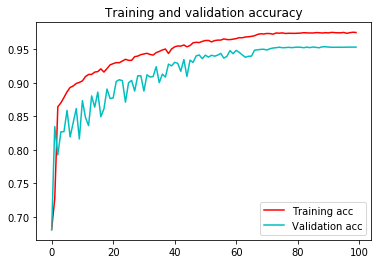

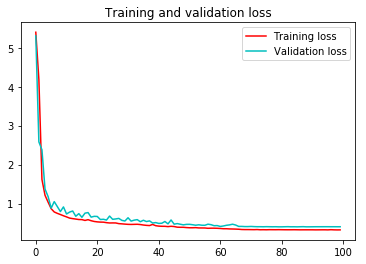

In [76]:
#fix timeout using  keras_tqdm progressbar http://rohitrawat.com/fixing-keras-hangups-in-jupyter-notebooks/
InteractiveShell.ast_node_interactivity = "none"

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc', color='r')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='c')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss', color='r')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='c')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## View results

Let's take a look at some of the results we achieved after an incomplete training run of 100 epochs.
Reference examples recommend training of around 500 epochs.

In [ ]:
from keras.models import load_model
#lrg_model = load_model('C:\\yourfolder\\ThursdayCheckpoint.h5')   #loading a model trained previousely
#model = load_model(os.path.join(backgroundsegmenter_dir,'TiramisuSmallModel_latest20180212.h5'))
model = load_model(os.path.join(backgroundsegmenter_dir,'TiramisuSmallModel_20180215.h5'))
print('model loaded')

In [77]:
sm_sz = (224, 224)
gen_test = segm_generator(test, test_labels, 1, out_sz=segm_sz, train=False)
gen = segm_generator(trn, trn_labels, bs=1, out_sz=segm_sz, train=False)

In [ ]:
print(test.shape, test_labels.shape, rnd_test)

In [78]:
preds = model.predict_generator(gen, rnd_trn)
preds_test =  model.predict_generator(gen_test, rnd_test)

In [79]:
print(preds.shape, preds_test.shape)

(199, 50176, 1) (50, 50176, 1)


In [91]:
print(PATH)

/home/syncweek/yourfolder/backgroundsegmenter/res224


In [93]:
save_array(os.path.join(PATH,'results/preds_train.bc'), preds)
save_array(os.path.join(PATH,'results/preds_test.bc'), preds_test)

In [101]:
idx=45
p=preds_test[idx]
print(p.shape)

(50176, 1)


In [102]:
p[p<.5] = 0
p[p>=.5]= 1
p=p.astype(np.int)

In [103]:
p = p.reshape((224,224))
print(p.shape)

(224, 224)


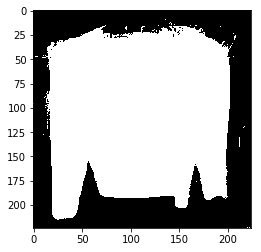

In [104]:
plt.imshow(p, cmap='binary');

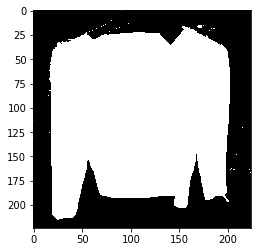

In [99]:
#plt.figure(figsize=(9,9))
#plt.imshow(test[idx]*0.3+0.4)
#img = 
plt.imshow(test_labels[idx].reshape(224,224), cmap='binary')
#plt.imshow(img)

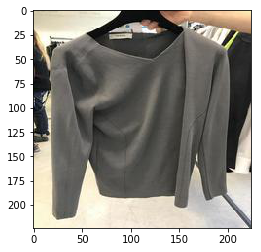

In [100]:
img = Image.open(fnames_test[idx]).resize(img_sz, Image.NEAREST)
plt.imshow(img)